###Composer Classifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import numpy as np


composer_map = {
    "Schubert": 9, "Mozart": 7, "Dvorak": 4,
    "Cambini": 3, "Haydn": 6, "Brahms": 2,
    "Faure": 5, "Ravel": 8, "Bach": 0, "Beethoven": 1
}

reverse_map = {v: k for k, v in composer_map.items()}


class StyleEncoder(nn.Module):
    def __init__(self, embedding_dim=128, num_composers=10):
        super(StyleEncoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
        )
        self.temporal = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.projection = nn.Linear(256, embedding_dim)
        self.composer_embedding = nn.Embedding(num_composers, embedding_dim)

    def forward(self, x, composer_embedding=None):
        x = self.cnn(x)
        x = self.temporal(x).squeeze(-1)
        x = self.projection(x)
        return x + composer_embedding


# Create the model

style_encoder = StyleEncoder().to(device)

# Load the checkpoint
checkpoint = torch.load("/content/drive/MyDrive/cs229Project/style_encoder-2.pth", map_location=device)
filtered_checkpoint = {k: v for k, v in checkpoint.items() if k in style_encoder.state_dict()}
style_encoder.load_state_dict(filtered_checkpoint, strict=False)
style_encoder.eval()

# Load audio waveform
waveform = torch.tensor(
    np.load('/content/drive/MyDrive/cs229Project/229Dataset/musicnet/processed_audio/1727.npy')
).to(device)
waveform = waveform.to(dtype=torch.float16)
# Make sure waveform has the right shape [batch, channels, time]
if waveform.dim() == 1:
    waveform = waveform.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
elif waveform.dim() == 2:
    waveform = waveform.unsqueeze(0)  # Add batch dimension

composer_embedding_weights = style_encoder.composer_embedding.weight.data

composer_embeddings_dict = {
    composer: composer_embedding_weights[composer_id].detach().cpu().numpy()
    for composer, composer_id in composer_map.items()
}
for composer, embedding in composer_embeddings_dict.items():
    print(f"{composer}: {embedding[:5]}...")  # Print the first 5 values for brevity


print(composer_embeddings_dict["Schubert"])
style_encoder = style_encoder.to(torch.float16)
composer_embeddings = torch.tensor(composer_embeddings_dict["Schubert"]).to(device)
composer_embeddings = composer_embeddings.to(dtype=torch.float16)
print(composer_embeddings.dtype)
print(waveform.dtype)
outputs_with_id = style_encoder(waveform, composer_embeddings)
print("Output shape with composer_id:", outputs_with_id.shape)
print(outputs_with_id)
print(device)



Schubert: [-0.0399006 -1.4581578  0.7540325 -0.3136256 -0.7847596]...
Mozart: [ 0.05876034  2.000688   -1.9079921  -1.1833687  -0.9618606 ]...
Dvorak: [-0.255268    0.17314005 -0.38424298 -1.2285194   0.93682635]...
Cambini: [-0.08229057  1.303195    0.40165764 -1.3665297  -1.1813307 ]...
Haydn: [-1.0088236   1.2965635   0.25496018  0.25001827  0.48092383]...
Brahms: [-0.11956131  0.57687473 -0.14041474 -0.21242541  0.2801856 ]...
Faure: [ 0.06443194  0.12758182  0.17273441 -2.7166872   0.5232171 ]...
Ravel: [-0.37951747 -2.3222933   1.1933309  -0.44496727 -0.07125596]...
Bach: [ 1.0189674  -0.03704567 -0.62848276  0.5494599   0.57478607]...
Beethoven: [-0.22611332  0.53072536 -2.9945054   1.186264   -0.8996345 ]...
[-3.9900597e-02 -1.4581578e+00  7.5403249e-01 -3.1362560e-01
 -7.8475958e-01  2.3423865e-01 -1.7927125e+00 -1.3447340e-01
 -9.9103272e-01  6.0617357e-01 -6.1353147e-01 -6.0587287e-01
  1.0860469e+00  3.6251536e-01  8.9232963e-01  6.0570133e-01
 -1.0701617e+00  6.2439948e-01

In [ ]:
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import soundfile as sf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import librosa

def extract_audio_segments(audio_path, target_duration=60.0, target_sample_rate=16000, max_pad=10):
    try:
        waveform, sr = librosa.load(audio_path, sr=None, mono=True)

        if sr != target_sample_rate:
            waveform = librosa.resample(waveform, orig_sr=sr, target_sr=target_sample_rate)

        samples_per_sec = target_sample_rate
        samples_per_min = int(target_duration * samples_per_sec)

        if len(waveform) < 3 * 60 * samples_per_sec:  # Need at least 3 minutes
            print(f"Skipping {audio_path}: Too short (less than 3 minutes).")
            return []

        extracted_samples = []
        for i in range(2):  # Extract only two segments
            start_sample = (i + 1) * 60 * samples_per_sec  # Start from minute 1
            end_sample = start_sample + samples_per_min

            if end_sample <= len(waveform):
                extracted_samples.append(waveform[start_sample:end_sample])
            else:
                missing_samples = end_sample - len(waveform)
                if missing_samples <= max_pad * samples_per_sec:
                    padded_waveform = np.pad(waveform[start_sample:], (0, missing_samples), mode='constant')
                    extracted_samples.append(padded_waveform)

        return extracted_samples

    except Exception as e:
        print(f"Skipping {audio_path} due to error: {e}")
        return []


def extract_style_features(audio_path, composer):

    segments = extract_audio_segments(audio_path)
    features = []

    for segment in segments:

        waveform = torch.tensor(segment).to(device)
        waveform = waveform.to(dtype=torch.float16)
        # Make sure waveform has the right shape [batch, channels, time]
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        elif waveform.dim() == 2:
            waveform = waveform.unsqueeze(0)  # Add batch dimension

        composer_embeddings = torch.tensor(composer_embeddings_dict[composer]).to(device)
        composer_embeddings = composer_embeddings.to(dtype=torch.float16)
        outputs_with_id = style_encoder(waveform, composer_embeddings)
        print("Output shape with composer_id:", outputs_with_id.shape)
        features.append(outputs_with_id.detach().cpu().numpy())
    return features

def create_dataset(csv_path):
    df = pd.read_csv(csv_path)
    features, labels = [], []
    i = 0

    for _, row in df.iterrows():
        try:
            if pd.isna(row['audio_path']) or row['audio_path'].strip().lower() == "nan.wav":
                continue
            for audio_feature in extract_style_features(row['audio_path'], row['composer']):
                features.append(audio_feature)
                labels.append(row['composer'])
            # print(f"{row['audio_path']} loaded successfully with sample rate")
            i+=1
            print(i)

        except Exception as e:
            print(f"Error processing {row['audio_path']}: {e}")

    return np.array(features), np.array(labels)


updated_csv_path = "/content/meta_audiopath.csv"
csv_path = updated_csv_path
X, y = create_dataset(csv_path)

# Encode labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Output shape with composer_id: torch.Size([1, 128])
Output shape with composer_id: torch.Size([1, 128])
1
Output shape with composer_id: torch.Size([1, 128])
Output shape with composer_id: torch.Size([1, 128])
2
Output shape with composer_id: torch.Size([1, 128])
Output shape with composer_id: torch.Size([1, 128])
3
Output shape with composer_id: torch.Size([1, 128])
Output shape with composer_id: torch.Size([1, 128])
4
Output shape with composer_id: torch.Size([1, 128])
Output shape with composer_id: torch.Size([1, 128])
5
Output shape with composer_id: torch.Size([1, 128])
Output shape with composer_id: torch.Size([1, 128])
6
Output shape with composer_id: torch.Size([1, 128])
Output shape with composer_id: torch.Size([1, 128])
7
Output shape with composer_id: torch.Size([1, 128])
Output shape with composer_id: torch.Size([1, 128])
8
Output shape with composer_id: torch.Size([1, 128])
Output shape with composer_id: torch.Size([1, 128])
9
Output shape with composer_id: torch.Size([1, 

In [ ]:



def build_classifier(num_classes):
    model = models.Sequential([
        layers.Input(shape=(1,128)),  # YAMNet embeddings are 1024-dimensional
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

Using device: cuda
Loaded data: X shape (558, 128), y shape (558,)
Epoch 1/50
Train Loss: 2.1241, Train Acc: 0.2691
Val Loss: 1.8147, Val Acc: 0.7500
Epoch 2/50
Train Loss: 1.3893, Train Acc: 0.7758
Val Loss: 0.9087, Val Acc: 0.9286
Epoch 3/50
Train Loss: 0.7195, Train Acc: 0.8812
Val Loss: 0.4975, Val Acc: 0.9554
Epoch 4/50
Train Loss: 0.3867, Train Acc: 0.9417
Val Loss: 0.2916, Val Acc: 0.9554
Epoch 5/50
Train Loss: 0.2365, Train Acc: 0.9529
Val Loss: 0.2029, Val Acc: 0.9554
Epoch 6/50
Train Loss: 0.1620, Train Acc: 0.9552
Val Loss: 0.1679, Val Acc: 0.9554
Epoch 7/50
Train Loss: 0.1301, Train Acc: 0.9709
Val Loss: 0.1483, Val Acc: 0.9554
Epoch 8/50
Train Loss: 0.1132, Train Acc: 0.9709
Val Loss: 0.1362, Val Acc: 0.9554
Early stopping at epoch 8


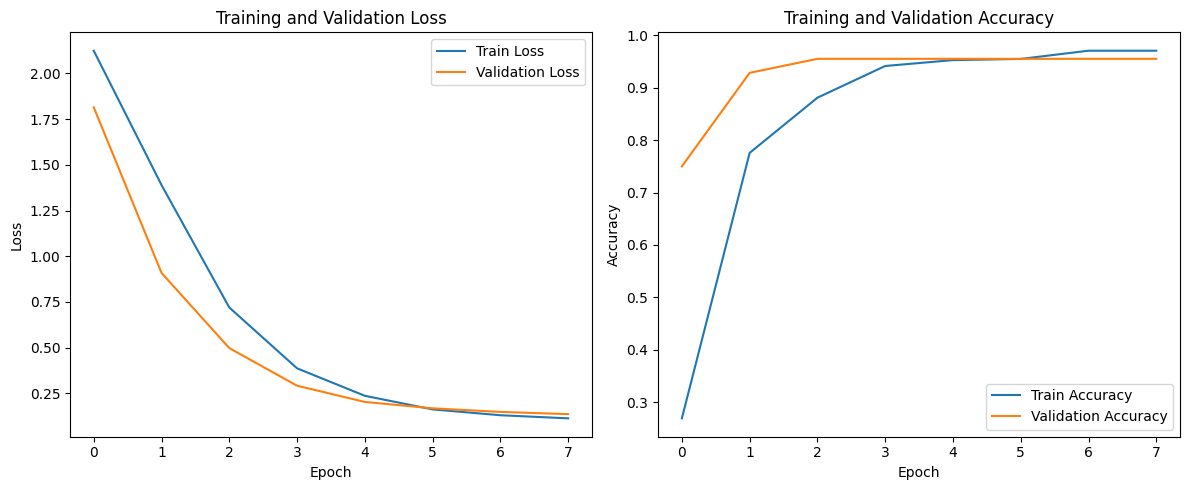

Best validation accuracy: 0.9554


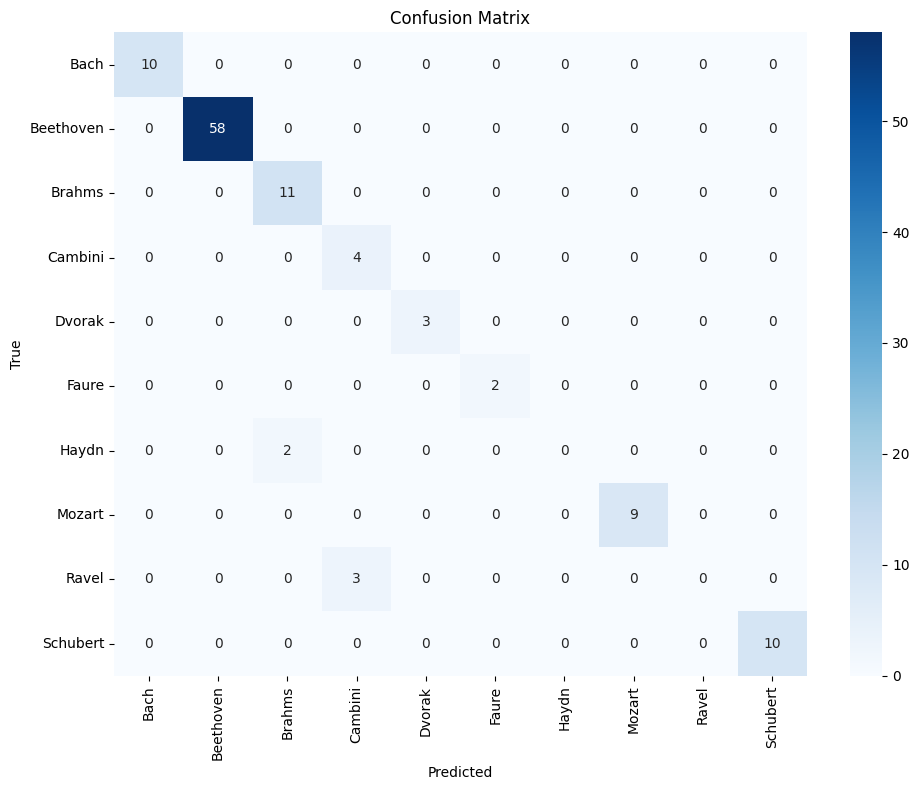


Classification Report:
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00        10
   Beethoven       1.00      1.00      1.00        58
      Brahms       0.85      1.00      0.92        11
     Cambini       0.57      1.00      0.73         4
      Dvorak       1.00      1.00      1.00         3
       Faure       1.00      1.00      1.00         2
       Haydn       0.00      0.00      0.00         2
      Mozart       1.00      1.00      1.00         9
       Ravel       0.00      0.00      0.00         3
    Schubert       1.00      1.00      1.00        10

    accuracy                           0.96       112
   macro avg       0.74      0.80      0.76       112
weighted avg       0.92      0.96      0.94       112

Model saved to composer_classifier_style_encoder.pth


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define composer mapping
composer_map = {
    "Schubert": 9, "Mozart": 7, "Dvorak": 4,
    "Cambini": 3, "Haydn": 6, "Brahms": 2,
    "Faure": 5, "Ravel": 8, "Bach": 0, "Beethoven": 1
}

reverse_map = {v: k for k, v in composer_map.items()}

# Custom dataset class
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        label = self.labels[idx]
        # Flatten the embedding if it's not already flat
        if len(embedding.shape) > 1:
            embedding = embedding.reshape(-1)
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Simple MLP classifier
class ComposerClassifier(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=64, num_classes=10, dropout_rate=0.3):
        super(ComposerClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=3):
    best_val_acc = 0
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_true = []

        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(embeddings)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss and predictions
            train_loss += loss.item() * embeddings.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_true.extend(labels.cpu().numpy())

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = accuracy_score(train_true, train_preds)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_true = []

        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)

                # Forward pass
                outputs = model(embeddings)
                loss = criterion(outputs, labels)

                # Track loss and predictions
                val_loss += loss.item() * embeddings.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_true, val_preds)

        # Track metrics for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_composer_classifier.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Plot training history
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()

    # Load best model for evaluation
    model.load_state_dict(torch.load('best_composer_classifier.pth'))

    return model, val_true, val_preds, best_val_acc

# Evaluation function
def evaluate_model(model, val_true, val_preds):
    # Create confusion matrix
    conf_matrix = confusion_matrix(val_true, val_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=[reverse_map[i] for i in range(len(reverse_map))],
                yticklabels=[reverse_map[i] for i in range(len(reverse_map))])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(val_true, val_preds,
                               target_names=[reverse_map[i] for i in range(len(reverse_map))]))

# Main function to load data and train the model
def main():
    # Load the embeddings and labels
    # Assuming your data is stored as numpy arrays
    X = np.load('/content/X_features_style_encoder.npy')  # Shape (558, 1, 128)
    y = np.load('/content/y_labels_style_encoder.npy')      # Shape (558,)

    # Flatten the embeddings if needed
    if len(X.shape) > 2:
        X = X.reshape(X.shape[0], -1)  # Reshape to (558, 128)

    print(f"Loaded data: X shape {X.shape}, y shape {y.shape}")

    # Create dataset
    dataset = EmbeddingDataset(X, y)

    # Split into train and validation sets (80/20)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize model
    input_dim = X.shape[1]  # Should be 128
    model = ComposerClassifier(input_dim=input_dim, hidden_dim=64, num_classes=len(composer_map)).to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Train model
    model, val_true, val_preds, best_val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
    )

    print(f"Best validation accuracy: {best_val_acc:.4f}")

    # Evaluate model
    evaluate_model(model, val_true, val_preds)

    # Save the model
    torch.save({
        'model_state_dict': model.state_dict(),
        'accuracy': best_val_acc,
    }, 'composer_classifier.pth')

    print("Model saved to composer_classifier_style_encoder.pth")

if __name__ == "__main__":
    main()

In [ ]:
# Save features (X) and labels (y)
np.save("X_features_style_encoder.npy", X)
np.save("y_labels_style_encoder.npy", y)
print("Saved features and labels successfully.")


Saved features and labels successfully.


###Visualization with t-SNE


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/cs229Project/229Dataset/musicnet/meta_audiopath.csv")
style_encoder = style_encoder.to(torch.float16)
composer_embedding_weights = style_encoder.composer_embedding.weight.data

composer_embeddings_dict = {
    composer: composer_embedding_weights[composer_id].detach().cpu().numpy()
    for composer, composer_id in composer_map.items()
}


print("Processing audio samples...")
all_embeddings = []
all_composers = []

# Iterate through all rows
for i, row in enumerate(df.itertuples()):
    if i % 10 == 0:  # Print progress every 10 samples
        print(f"Processing sample {i+1}/{len(df)}")

    try:
        composer = row[2]
        audio_path = row[4]


        # Skip if composer not in our map
        if composer not in composer_map:
            continue

        # Load waveform
        waveform = torch.tensor(np.load(audio_path)).to(device)
        waveform = waveform.to(dtype=torch.float16)

        # Make sure waveform has the right shape [batch, channels, time]
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        elif waveform.dim() == 2:
            waveform = waveform.unsqueeze(0)  # Add batch dimension

        # Get composer embedding
        composer_embedding = torch.tensor(composer_embeddings_dict[composer]).to(device)
        composer_embedding = composer_embedding.to(dtype=torch.float16)

        # Get style embedding from encoder
        with torch.no_grad():
            output = style_encoder(waveform, composer_embedding)

        # Add to our collections
        print(output.shape)
        all_embeddings.append(output.cpu().numpy().squeeze())
        all_composers.append(composer)

    except Exception as e:
        print(f"Error processing sample {i}: {e}")

# Convert to numpy arrays
all_embeddings = np.array(all_embeddings)
print(f"Processed {len(all_embeddings)} samples successfully")

# Get mean embeddings (these are already in composer_embeddings_dict)
all_mean_embeddings = np.array([composer_embeddings_dict[composer] for composer in set(all_composers)])

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import seaborn as sns


In [ ]:
def visualize_embeddings(all_embeddings, all_composers, composer_embeddings_dict):
    # Get unique composers and set up colors
    unique_composers = list(set(all_composers))
    palette = sns.color_palette("hsv", len(unique_composers))
    composer_to_color = {c: i for i, c in enumerate(unique_composers)}


    fig, axs = plt.subplots(2, 1, figsize=(14, 20))


    print("Computing t-SNE projection...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_embeddings)-1))


    mean_embeddings = np.array([composer_embeddings_dict[c] for c in unique_composers])
    combined_embeddings = np.vstack([all_embeddings, mean_embeddings])
    combined_tsne = tsne.fit_transform(combined_embeddings)


    tsne_result = combined_tsne[:len(all_embeddings)]
    tsne_means = combined_tsne[len(all_embeddings):]


    for i, composer in enumerate(unique_composers):
        composer_indices = [j for j, c in enumerate(all_composers) if c == composer]
        axs[0].scatter(
            tsne_result[composer_indices, 0],
            tsne_result[composer_indices, 1],
            color=palette[i],
            alpha=0.5,
            label=composer
        )


    for i, composer in enumerate(unique_composers):
        axs[0].scatter(
            tsne_means[i, 0],
            tsne_means[i, 1],
            color=palette[i],
            s=200,
            marker='*',
            edgecolors='black'
        )
        axs[0].annotate(
            f"Mean {composer}",
            (tsne_means[i, 0], tsne_means[i, 1]),
            fontsize=12,
            fontweight='bold'
        )

    axs[0].set_title('t-SNE Visualization of Style Embeddings', fontsize=16)
    axs[0].grid(True, linestyle='--', alpha=0.7)


    print("Computing UMAP projection...")
    reducer = umap.UMAP(n_components=2, random_state=42, min_dist=0.1)


    combined_umap = reducer.fit_transform(combined_embeddings)

    umap_result = combined_umap[:len(all_embeddings)]
    umap_means = combined_umap[len(all_embeddings):]


    for i, composer in enumerate(unique_composers):
        composer_indices = [j for j, c in enumerate(all_composers) if c == composer]
        axs[1].scatter(
            umap_result[composer_indices, 0],
            umap_result[composer_indices, 1],
            color=palette[i],
            alpha=0.5
        )


    for i, composer in enumerate(unique_composers):
        axs[1].scatter(
            umap_means[i, 0],
            umap_means[i, 1],
            color=palette[i],
            s=200,
            marker='*',
            edgecolors='black'
        )
        axs[1].annotate(
            f"Mean {composer}",
            (umap_means[i, 0], umap_means[i, 1]),
            fontsize=12,
            fontweight='bold'
        )

    axs[1].set_title('UMAP Visualization of Style Embeddings', fontsize=16)
    axs[1].grid(True, linestyle='--', alpha=0.7)


    handles, labels = [], []
    for i, composer in enumerate(unique_composers):
        handle = plt.Line2D([0], [0], marker='o', color=palette[i],
                           label=composer, markersize=10, linestyle='')
        handles.append(handle)
        labels.append(composer)


    mean_handle = plt.Line2D([0], [0], marker='*', color='gray',
                           markersize=15, markeredgecolor='black',
                           linestyle='', label='Mean Embedding')
    handles.append(mean_handle)
    labels.append('Mean Embedding')

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
              fancybox=True, shadow=True, ncol=min(5, len(unique_composers)+1), fontsize=12)

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.savefig('style_embeddings_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()


print("Visualizing embeddings...")
visualize_embeddings(all_embeddings, all_composers, composer_embeddings_dict)


np.save('composer_embeddings.npy', composer_embeddings_dict)
print("Composer embeddings saved to composer_embeddings.npy")